In [ ]:
!pip install langchain==0.3.24 -q
!pip install langchain-openai -q
!pip install langchain-community -q
!pip install langgraph -q

# !pip install langchain-tavily -q
# !pip install pyowm -qU

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-community 0.3.24 requires langchain<1.0.0,>=0.3.25, but you have langchain 0.3.24 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 85.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 35.6 MB/s eta 0:00:00


In [ ]:
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import BaseMessage, ToolMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode

In [ ]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [ ]:
import os
from google.colab import userdata

os.environ['OPENAI_API_KEY'] = userdata.get('API_KEY')

In [ ]:
llm = ChatOpenAI(model = "gpt-4o")

In [ ]:
# from langchain_tavily import TavilySearch
# from langchain_community.utilities import OpenWeatherMapAPIWrapper
from langchain.agents import load_tools

@tool
def addtion(a: int, b:int):
    """This is the addition function that adds 2 numbers"""
    return a + b

@tool
def subtraction(a: int, b: int):
    """This is the subtraction function that subtract 2 numbers"""
    return a - b

@tool
def multiplication(a: int, b: int):
    """This is the multiplication function that multiply 2 numbers"""
    return a * b

@tool
def division(a: int, b: int):
    """This is the division function that divide 2 numbers"""
    return a / b

# os.environ["OPENWEATHERMAP_API_KEY"] = userdata.get('OPENWEATHERMAP_API_KEY')
# os.environ['TAVILY_API_KEY'] = userdata.get('TAVILY_API_KEY')

# # Initialize DuckDuckGo search tool
# search_tool = TavilySearch()

# # Initialize OpenWeatherMap tool
# weather = OpenWeatherMapAPIWrapper()

# weather_tool = load_tools(["openweathermap-api"], llm)[0]

In [ ]:
tools = [addtion, subtraction, multiplication, division]
# tools = [search_tool, weather_tool]

In [ ]:
llm_with_tools = llm.bind_tools(tools)

In [ ]:
def llm_call(state:AgentState) -> AgentState:
    system_prompt = SystemMessage(content=
        "You are an intelligent AI assistant."
    )
    response = llm_with_tools.invoke([system_prompt] + state["messages"])
    return {"messages": [response]}


def decision(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return "end"
    else:
        return "continue"

In [ ]:
graph = StateGraph(AgentState)

graph.add_node("agent", llm_call)
tool_node = ToolNode(tools=tools)
graph.add_node("tools", tool_node)

graph.set_entry_point("agent")
graph.add_conditional_edges(
    "agent",
    decision,
    {
        "continue": "tools",
        "end": END,
    },
)
graph.add_edge("tools", "agent")

app = graph.compile()

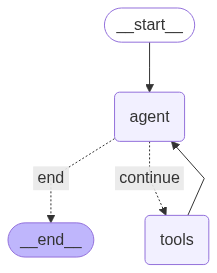

In [ ]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

In [ ]:
inputs = {"messages": [("user", "Add 40 and 12. Then multiply the result by 6.")]}
print_stream(app.stream(inputs, stream_mode="values"))

================================ Human Message =================================

Add 40 and 12. Then multiply the result by 6.
================================== Ai Message ==================================

First, add 40 and 12:

\[ 40 + 12 = 52 \]

Next, multiply the result by 6:

\[ 52 \times 6 = 312 \]

So, the final result is 312.


In [ ]:
inputs = {"messages": [("user", "What is the current temperature in Colombo?")]}
print_stream(app.stream(inputs, stream_mode="values"))

================================ Human Message =================================

What is the current temperature in Colombo?
================================== Ai Message ==================================
Tool Calls:
  open_weather_map (call_HLVW9DqUy98ctFgEr2GSqJsi)
 Call ID: call_HLVW9DqUy98ctFgEr2GSqJsi
  Args:
    location: Colombo
================================= Tool Message =================================
Name: open_weather_map

In Colombo, the current weather is as follows:
Detailed status: overcast clouds
Wind speed: 9.72 m/s, direction: 253°
Humidity: 83%
Temperature: 
  - Current: 28.97°C
  - High: 28.97°C
  - Low: 28.97°C
  - Feels like: 35.32°C
Rain: {}
Heat index: None
Cloud cover: 98%
================================== Ai Message ==================================

The current temperature in Colombo is 28.97°C, and it feels like 35.32°C. The weather is overcast with a cloud cover of 98% and a humidity of 83%.


In [ ]:
inputs = {"messages": [("user", "what is codepro lk?")]}
print_stream(app.stream(inputs, stream_mode="values"))

================================ Human Message =================================

what is codepro lk?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_Wc3ueCPaikDvCQ397P8uGLza)
 Call ID: call_Wc3ueCPaikDvCQ397P8uGLza
  Args:
    query: CodePro LK
================================= Tool Message =================================
Name: tavily_search

{"query": "CodePro LK", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "CodePRO LK - Implement Yourself", "url": "https://codeprolk.com/", "content": "CodePRO LK is a technology-driven platform dedicated to empowering individuals and businesses through innovative services and cutting-edge education. In today's AI-driven world, every industry is leveraging the power of artificial intelligence to revolutionize operations and enhance capabilities.", "score": 0.9145431, "raw_content": null}, {"title": "CodePRO LK - Telegram", "url": "https://t.me/s/